In [0]:
import os
import shutil
import json
import re
import os
import datetime
from itertools import permutations 
import numpy as np
import time
from matplotlib import pyplot as plt
from google.colab import drive
import imageio
import glob
from PIL import Image
from functools import reduce
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import itertools
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as ohe

import seaborn as sn
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('punkt')
# from gensim.models import Word2Vec


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "./drive/My Drive/cs472/data/data.pkl"
data_path2 = "./drive/My Drive/cs472/data/data2.pkl"

clean_data_path = "./drive/My Drive/cs472/data/clean_data.pkl"
clean_data_path2 = "./drive/My Drive/cs472/data/clean_data2.pkl"

word_dict_path = "./drive/My Drive/cs472/data/word_dict.pkl"
name_dict_path = "./drive/My Drive/cs472/data/name_dict.pkl"

word_encoder_path = "./drive/My Drive/cs472/models/word_encoder.pkl"
name_encoder_path = "./drive/My Drive/cs472/models/name_encoder.pkl"

c_word_encoder_path = "./drive/My Drive/cs472/models/c_word_encoder.pkl"
c_name_encoder_path = "./drive/My Drive/cs472/models/c_name_encoder.pkl"


word_decoder_path = "./drive/My Drive/cs472/models/word_decoder.pkl"
name_decoder_path = "./drive/My Drive/cs472/models/name_decoder.pkl"

regressor_path = "./drive/My Drive/cs472/models/regressor.pkl"
classifier_path = "./drive/My Drive/cs472/models/classifier.pkl"
classifier_path2 = "./drive/My Drive/cs472/models/classifier2.pkl"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
class MovieRatings(Dataset):

    def __init__(self, word_encoder, name_encoder, file_path=clean_data_path2, test=False, test_split=.3,classifier=False):
        """
        params:
            genre int: 1-14 corrisponding to just training 
            on a certain genre or not
        """
        super(MovieRatings, self).__init__()

        self.classifier = classifier
        self.test = test

        self.word_embeds, self.word_dict, self.word_embed_len, self.word_max_length  = self._get_embedding(word_dict_path)
        self.name_embeds, self.name_dict, self.name_embed_len, self.name_max_length = self._get_embedding(name_dict_path)

        data = pd.read_pickle(file_path)
        s_rating_dummies = pd.get_dummies(data.s_rating, drop_first=True)
        genre_dummies = pd.get_dummies(data.genre, drop_first=True)

        n = int(len(data)*test_split)

        self.test_data = data.iloc[:n,:]
        self.test_s_rating_dummies = s_rating_dummies.iloc[:n,:]
        self.test_genre_dummies = genre_dummies.iloc[:n,:]

        self.train_data = data.iloc[n:,:]
        self.train_s_rating_dummies = s_rating_dummies.iloc[n:,:]
        self.train_genre_dummies = genre_dummies.iloc[n:,:]


        self.word_encoder = word_encoder 
        self.name_encoder = name_encoder


    def _get_embedding(self,path_):

        # get name embedding space
        dict_ = pickle.load( open(path_, "rb" ) ) 

        # make embedding space for names
        vocab_size = len(dict_) - 2
        
        embed_length = dict_['em_length']
        return nn.Embedding(vocab_size, embed_length), dict_, embed_length, dict_['max_length']


    def __getitem__(self, i):
        if self.test:
            data = self.test_data
            s_rating_dummies = self.test_s_rating_dummies
            genre_dummies = self.test_genre_dummies
        else:
            data = self.train_data
            s_rating_dummies = self.train_s_rating_dummies
            genre_dummies = self.train_genre_dummies

        actor = data.actor.iloc[i].lower()
        director = data.director.iloc[i].lower()

        title_tokens = word_tokenize(data.title.iloc[i].lower())
        text_tokens = word_tokenize(data.description.iloc[i].lower())

        word_idx = torch.tensor([],dtype=torch.long)

        for t in text_tokens + title_tokens:
            idx = torch.tensor([self.word_dict[t]])
            word_idx = torch.cat((word_idx, idx),0)
        
        actor_idx = torch.tensor([self.name_dict[actor]], dtype=torch.long)
        director_idx = torch.tensor([self.name_dict[director]],dtype=torch.long)

        name_idx = torch.cat((actor_idx, director_idx),0)

        run_time = torch.Tensor([data.runtime.iloc[i]]).cuda()
        s_rating = torch.Tensor(s_rating_dummies.iloc[i].values).cuda()
        genre = torch.Tensor(genre_dummies.iloc[i].values).cuda()

        if self.classifier:
            label = float(data.rating_class.iloc[i])
        else:
            label = float(data.rating_label.iloc[i])

        w_encoder_hidden = self.word_encoder.initHidden()
        n_encoder_hidden = self.name_encoder.initHidden()

        # encode description, title and names 
        for e_i in range(len(word_idx)):
            encoder_output, w_encoder_hidden = self.word_encoder(word_idx[e_i].cuda(), w_encoder_hidden)

        for e_i in range(len(name_idx)):
            encoder_output, n_encoder_hidden = self.name_encoder(name_idx[e_i].cuda(), n_encoder_hidden)

        w_encoder_hidden = w_encoder_hidden.squeeze(0).squeeze(0)
        n_encoder_hidden = n_encoder_hidden.squeeze(0).squeeze(0)

        return torch.cat((w_encoder_hidden,n_encoder_hidden, s_rating, run_time, genre), dim=0), label

    def __len__(self):
        if self.test:
            return len(self.test_data)
        else:
            return len(self.train_data)


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class ClassifierNet(nn.Module):

    def __init__(self, in_dim=64,out_dim=20):
        super(ClassifierNet, self).__init__()

        # another way to define a network
        self.net = nn.Sequential(
                        nn.Linear(in_dim, 100),
                        nn.LeakyReLU(),
                        nn.Linear(100, 150),
                        nn.LeakyReLU(),
                        nn.Linear(150, 100),
                        nn.LeakyReLU(),
                        nn.Linear(100, 50),
                        nn.LeakyReLU(),
                        nn.Linear(50, out_dim),
                        nn.Softmax())

    def forward(self, x):
        return self.net(x)

In [0]:
def train_classifier(epochs=20, print_every=10):

    word_encoder = torch.load(c_word_encoder_path)
    name_encoder = torch.load(c_name_encoder_path)
    classifier = torch.load(classifier_path2).cuda()

    data_set = MovieRatings(word_encoder, name_encoder, classifier=True)
    data_loader = DataLoader(data_set, batch_size=64, shuffle=True)
    n = len(data_loader)

    optimizer = torch.optim.Adam(itertools.chain(word_encoder.parameters(),
                                                 name_encoder.parameters(),
                                                 classifier.parameters()))
    loss_func = torch.nn.CrossEntropyLoss()
    losses = []
    
    for e in range(1,epochs+1):
        print("Epoch", e)
        epoch_loss = 0
        print_loss_total = 0

        for i, (x, label) in enumerate(data_loader):

            # run regression and get loss
            pred_y = classifier(x)
            loss = loss_func(pred_y, label.long().cuda())

            epoch_loss += loss.item()
            losses.append(loss.item())

            if i % print_every == 0:
                # print(pred_y)
                print("Step", i, ":",np.mean(losses[-10:]))
                
                torch.save(classifier, classifier_path2)
                torch.save(word_encoder, c_word_encoder_path)
                torch.save(name_encoder, c_name_encoder_path)

            optimizer.zero_grad()   
            loss.backward(retain_graph=True)
            optimizer.step()

        print("Average Epoch Loss:", epoch_loss/n)

    return data_set, classifier

In [0]:
# torch.save(ClassifierNet(), classifier_path2)
train_classifier()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ClassifierNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ClassifierNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Step 0 : 2.995563507080078
Step 10 : 2.9558850288391114
Step 20 : 2.947283148765564
Step 30 : 2.9066440582275392
Step 40 : 2.907702159881592
Step 50 : 2.883261775970459
Step 60 : 2.823415184020996
Step 70 : 2.789187121391296
Step 80 : 2.779052662849426
Step 90 : 2.8227931022644044
Step 100 : 2.7268621206283568
Step 110 : 2.715012454986572
Step 120 : 2.716008925437927
Step 130 : 2.7206469058990477
Step 140 : 2.6925158977508543
Step 150 : 2.719469976425171
Step 160 : 2.683630347251892
Step 170 : 2.6506195068359375
Step 180 : 2.6841196060180663
Step 190 : 2.675875759124756
Step 200 : 2.6728278160095216
Step 210 : 2.675901436805725
Step 220 : 2.694512629508972
Step 230 : 2.676478314399719
Step 240 : 2.7012238264083863
Step 250 : 2.660939598083496
Step 260 : 2.710917592048645
Step 270 : 2.7171518325805666
Step 280 : 2.6956948041915894
Step 290 : 2.717055630683899
Average Epoch Loss: 2.7494277103180034
Epoch 2
Step 0 : 2.713769483566284
Step 10 : 2.6596641540527344
Step 20 : 2.67798104286193

(<__main__.MovieRatings at 0x7fa501609e10>, ClassifierNet(
   (net): Sequential(
     (0): Linear(in_features=64, out_features=100, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=100, out_features=150, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=150, out_features=100, bias=True)
     (5): LeakyReLU(negative_slope=0.01)
     (6): Linear(in_features=100, out_features=50, bias=True)
     (7): LeakyReLU(negative_slope=0.01)
     (8): Linear(in_features=50, out_features=20, bias=True)
     (9): Softmax(dim=None)
   )
 ))

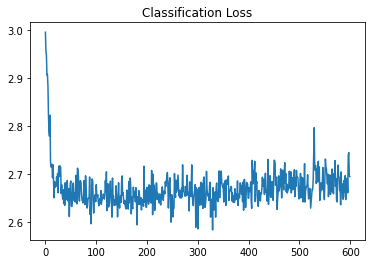

In [0]:
a = [2.995563507080078,2.9558850288391114,2.947283148765564,2.9066440582275392,2.907702159881592,2.883261775970459,2.823415184020996,2.789187121391296,2.779052662849426,2.8227931022644044,2.7268621206283568,2.715012454986572,2.716008925437927,2.7206469058990477,2.6925158977508543,2.719469976425171,2.683630347251892,2.6506195068359375,2.6841196060180663,2.675875759124756,2.6728278160095216,2.675901436805725,2.694512629508972,2.676478314399719,2.7012238264083863,2.660939598083496,2.710917592048645,2.7171518325805666,2.6956948041915894,2.717055630683899,2.713769483566284,2.6596641540527344,2.6779810428619384,2.6599958181381225,2.6481714487075805,2.667499041557312,2.6384669303894044,2.6642219543457033,2.6350369453430176,2.681968259811401,2.6460263967514037,2.659193181991577,2.65820734500885,2.6868730783462524,2.647498631477356,2.6437753677368163,2.669598388671875,2.6116196155548095,2.6567479372024536,2.681145691871643,2.6857903242111205,2.6342727899551392,2.6324453115463258,2.6438514947891236,2.677182674407959,2.6815800189971926,2.6546190977096558,2.644098711013794,2.6605616569519044,2.641837167739868,2.697480845451355,2.667337965965271,2.638008880615234,2.712519645690918,2.7096649646759032,2.6945916175842286,2.653545594215393,2.643843340873718,2.6841779470443727,2.6865278005599977,2.682640314102173,2.6585742473602294,2.6466468572616577,2.643152189254761,2.639830207824707,2.6571822643280028,2.686712908744812,2.6804556846618652,2.636671710014343,2.6964980363845825,2.672049069404602,2.647617983818054,2.629294204711914,2.6349066495895386,2.649648070335388,2.650280404090881,2.65215117931366,2.6939497232437133,2.616186022758484,2.63382408618927,2.5965949296951294,2.676548790931702,2.689904522895813,2.685997414588928,2.646169567108154,2.618916130065918,2.6433613538742065,2.6550794363021852,2.657250189781189,2.6426051378250124,2.6779310941696166,2.657448959350586,2.653198075294495,2.656991171836853,2.643322563171387,2.634359931945801,2.6363833427429197,2.6492053031921388,2.6395161628723143,2.665878176689148,2.637246108055115,2.644380807876587,2.64951913356781,2.649756407737732,2.6587032794952394,2.6507848262786866,2.6480210065841674,2.6568017482757567,2.6866857051849364,2.662629270553589,2.7048323154449463,2.624026298522949,2.645052456855774,2.679999566078186,2.631672430038452,2.6329877853393553,2.6405871629714968,2.6766517162323,2.6853927612304687,2.6577791929244996,2.638598823547363,2.6104493141174316,2.691853380203247,2.6503512144088743,2.6543225288391112,2.6347076177597044,2.6348766565322874,2.6466047525405885,2.635811471939087,2.67573721408844,2.654780054092407,2.6462021350860594,2.6109724044799805,2.652201843261719,2.681988024711609,2.641647458076477,2.6292216777801514,2.6488083600997925,2.6547756433486938,2.6413793325424195,2.6857937574386597,2.6963429689407348,2.656136918067932,2.661332845687866,2.64193274974823,2.6383834362030028,2.6452688694000246,2.6355459690093994,2.6292258739471435,2.6276130199432375,2.6668482780456544,2.647025394439697,2.6613649845123293,2.627246308326721,2.6845503091812133,2.639883303642273,2.6572956085205077,2.6920475006103515,2.6699132204055784,2.617141532897949,2.6524388551712037,2.630285954475403,2.6280597925186155,2.672826552391052,2.6563249826431274,2.6526664018630983,2.664379835128784,2.6423896312713624,2.671863317489624,2.6652117013931274,2.5943474769592285,2.652678346633911,2.6360714197158814,2.643584632873535,2.6656188488006594,2.6575887203216553,2.636727452278137,2.6451053857803344,2.651056098937988,2.625399374961853,2.6474018335342406,2.6422757625579836,2.6462008237838743,2.6333327293395996,2.7164737462997435,2.6459567308425904,2.6412853002548218,2.6666515588760378,2.631293511390686,2.6311232089996337,2.6725667238235475,2.644070029258728,2.6596885681152345,2.637499737739563,2.6777254343032837,2.6442275762557985,2.65402410030365,2.6751540660858155,2.639826250076294,2.707691526412964,2.6890777111053468,2.615577721595764,2.699453520774841,2.657463216781616,2.6771865367889403,2.6241851091384887,2.6330310583114622,2.66185839176178,2.68188636302948,2.6812491416931152,2.647346258163452,2.659982752799988,2.6479344367980957,2.64497971534729,2.640199375152588,2.6587504625320433,2.6404163599014283,2.6359002113342287,2.6488065481185914,2.6679220676422117,2.6733941555023195,2.6622400522232055,2.6454416513442993,2.6621830701828,2.6650721073150634,2.6590599060058593,2.6841361045837404,2.674699878692627,2.6876128673553468,2.692114329338074,2.7033631086349486,2.6785778522491457,2.6294533252716064,2.661625099182129,2.6838042736053467,2.692515420913696,2.6416842699050904,2.6000775575637816,2.655679726600647,2.6571914672851564,2.648085045814514,2.6107777833938597,2.6291872024536134,2.629264307022095,2.7012170791625976,2.6647778034210203,2.6515034675598144,2.68749053478241,2.662885069847107,2.670060658454895,2.6846845149993896,2.6982158422470093,2.6703983783721923,2.6545239686965942,2.666400742530823,2.6510120630264282,2.664303779602051,2.6500282764434813,2.670911502838135,2.6523613214492796,2.71943678855896,2.664701008796692,2.6743662357330322,2.662592363357544,2.6564316034317015,2.653928446769714,2.6561279773712156,2.675196099281311,2.6550658464431764,2.697823739051819,2.665707731246948,2.659261178970337,2.6564378261566164,2.623277282714844,2.6839009046554567,2.659880828857422,2.653776216506958,2.6778650522232055,2.719303607940674,2.653346633911133,2.6436568021774294,2.634474849700928,2.6545193433761596,2.6607835054397584,2.6670812129974366,2.678478980064392,2.5893996715545655,2.67163667678833,2.6655295848846436,2.655928921699524,2.5862274408340453,2.6687365770339966,2.671070599555969,2.672036647796631,2.635194253921509,2.6715484142303465,2.683028769493103,2.6619577407836914,2.6361929416656493,2.679801344871521,2.6286518812179565,2.6875905275344847,2.694136548042297,2.65820574760437,2.6307941675186157,2.6365045309066772,2.6515166044235228,2.7058233261108398,2.6697777986526487,2.6580312967300417,2.654070329666138,2.6592832088470457,2.645202660560608,2.6768128633499146,2.683225703239441,2.6105586290359497,2.64768271446228,2.6478383779525756,2.6466254711151125,2.583850383758545,2.6717607498168947,2.624880003929138,2.626283550262451,2.6276702642440797,2.6631855249404905,2.6105183124542237,2.671335554122925,2.681681823730469,2.6467774152755736,2.6610259771347047,2.6430146217346193,2.6787508964538573,2.7067744731903076,2.650909900665283,2.699737238883972,2.681483840942383,2.706387448310852,2.6843620777130126,2.676349067687988,2.672200059890747,2.671670389175415,2.641923499107361,2.6811798572540284,2.656561803817749,2.6868349075317384,2.6348042488098145,2.6879461288452147,2.6815515518188477,2.67899911403656,2.680417799949646,2.696088671684265,2.645120859146118,2.6625604152679445,2.663836693763733,2.6692807197570803,2.6737679481506347,2.674396538734436,2.644188475608826,2.6608609676361086,2.648434567451477,2.6408601999282837,2.65470232963562,2.641127824783325,2.6695197343826296,2.6466352939605713,2.6496348857879637,2.6593445539474487,2.6469205617904663,2.685893750190735,2.634845018386841,2.6480833292007446,2.658301854133606,2.6508004665374756,2.681594491004944,2.681159162521362,2.670335865020752,2.6576037645339965,2.6764913320541384,2.6425726652145385,2.683388090133667,2.6249130010604858,2.688639736175537,2.688935661315918,2.6627158880233766,2.630322480201721,2.6593215703964233,2.6828277587890623,2.680244207382202,2.6791630744934083,2.6500558853149414,2.6499744415283204,2.6721786975860597,2.663938355445862,2.6641429901123046,2.683818554878235,2.643155908584595,2.6287177085876463,2.7287527322769165,2.692049980163574,2.679733157157898,2.7073924779891967,2.704354453086853,2.726540970802307,2.642824959754944,2.7030390739440917,2.679279160499573,2.684786629676819,2.653645396232605,2.637652802467346,2.632697892189026,2.666110134124756,2.66245493888855,2.647334933280945,2.644096517562866,2.660896372795105,2.6591670751571654,2.6700323104858397,2.6936683177948,2.6750482082366944,2.6893791437149046,2.6812855005264282,2.6578057527542116,2.6876535654067992,2.701906991004944,2.662460446357727,2.6669490575790404,2.6439449310302736,2.653440999984741,2.730499601364136,2.637090063095093,2.6654006958007814,2.6721259117126466,2.6967511653900145,2.6551029443740846,2.651593232154846,2.6785866975784303,2.6845913410186766,2.661629581451416,2.645491623878479,2.6731177806854247,2.728666877746582,2.728834891319275,2.722924256324768,2.676890993118286,2.6890658855438234,2.6937659740448,2.6265804767608643,2.6491842031478883,2.6633638620376585,2.696422481536865,2.6649062871932983,2.6728625535964965,2.6754634380340576,2.710952973365784,2.6828635692596436,2.6506806373596192,2.7029072046279907,2.708270049095154,2.6837870359420775,2.667193651199341,2.703431487083435,2.723755192756653,2.68076605796814,2.701457381248474,2.6635917901992796,2.6796875,2.6607234477996826,2.6657879829406737,2.6672120094299316,2.6769067287445067,2.706064820289612,2.6890718221664427,2.670201873779297,2.7048712730407716,2.6609041929244994,2.6850846290588377,2.6929946660995485,2.667468476295471,2.683390235900879,2.6951843023300173,2.709266471862793,2.6530251264572144,2.6923369407653808,2.6743397235870363,2.70783212184906,2.6956298112869264,2.693776988983154,2.692131209373474,2.666912150382996,2.6484630823135378,2.6638433933258057,2.678970289230347,2.701470732688904,2.650543141365051,2.693626952171326,2.6640465021133424,2.6921937227249146,2.642132377624512,2.68883695602417,2.6718849897384644,2.721912670135498,2.6418448448181153,2.6665619134902956,2.670845055580139,2.6749661684036257,2.6768566131591798,2.6987046003341675,2.6670130014419557,2.6483535766601562,2.662630295753479,2.6702809572219848,2.668678402900696,2.6291563510894775,2.6422251224517823,2.6563161849975585,2.6690187454223633,2.6679179430007935,2.688403272628784,2.7468501806259153,2.7967774152755736,2.7085891723632813,2.717710328102112,2.717862439155579,2.680508852005005,2.6886855125427247,2.7121833086013796,2.683636784553528,2.726893925666809,2.6876921892166137,2.7149120569229126,2.6453571796417235,2.6579380512237547,2.667152237892151,2.6823008060455322,2.6671820878982544,2.6829272747039794,2.713746690750122,2.6749297618865966,2.667501759529114,2.6469347715377807,2.6940194606781005,2.7314858198165894,2.715956616401672,2.710932803153992,2.6968642711639403,2.679871845245361,2.7000176906585693,2.6530938863754274,2.6721853017807007,2.6687154293060305,2.6984118938446047,2.657765293121338,2.671868109703064,2.6651565790176392,2.7107126712799072,2.6631942272186278,2.6672784090042114,2.659238314628601,2.701156830787659,2.689028739929199,2.7281519412994384,2.674586868286133,2.6906131982803343,2.645316171646118,2.642187762260437,2.69528751373291,2.7191126108169557,2.693685221672058,2.693402099609375,2.665759873390198,2.6733865261077883,2.6361106634140015,2.7046825885772705,2.6604273080825807,2.679718327522278,2.6499545097351076,2.6476078033447266,2.654371666908264,2.6871862173080445,2.6625229120254517,2.6969822883605956,2.6468912601470946,2.691471815109253,2.6891996383666994,2.6908370733261107,2.661075210571289,2.739030623435974,2.7449878692626952,2.696165919303894,2.6949860095977782]

plt.plot(a)
plt.title("Classification Loss")
plt.show()

In [0]:
def confusion_matrix(filename=classifier_path2, plot=False):
    
    model = torch.load(filename).cuda().eval()

    num_classes = 10
    matrix = np.empty((num_classes,num_classes))
    
    word_encoder = torch.load(c_word_encoder_path).eval()
    name_encoder = torch.load(c_name_encoder_path).eval()

    data_set = MovieRatings(word_encoder, name_encoder, test=False, classifier=True)
    data_loader = DataLoader(data_set, batch_size=1, shuffle=True)
    n = len(data_loader)

    guesses = []
    labels = []
    
    for i, (x, label) in enumerate(data_loader):
        # get model guess
        y = model(x.cuda())
        guesses.append(y.argmax().item())
        labels.append(label.item())

    acc = sum(np.array(guesses) == np.array(labels))/len(guesses)
    print("Accuracy:", acc)
        
    conf_matrix = cm(labels,guesses)

    if plot:
        plt.figure(figsize = (10,7))
        sn.heatmap(conf_matrix, annot=True)
        plt.title("Confusion Matrix for CIFAR10")
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        # plt.savefig(folder + filename + "_confusion.jpg")
        plt.show()
    
    return conf_matrix, acc

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.3957244655581948


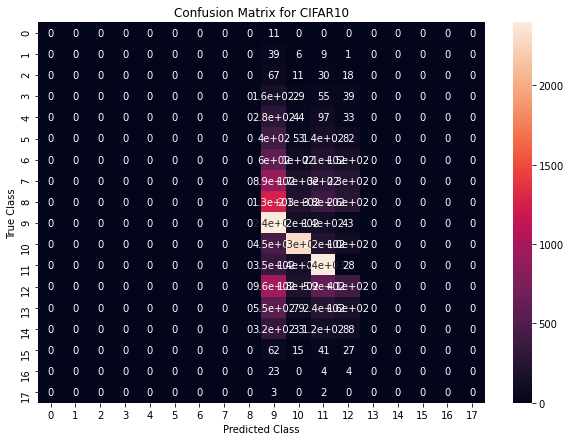

(array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,   11,    0,
            0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,   39,    6,
            9,    1,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,   67,   11,
           30,   18,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,  159,   29,
           55,   39,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,  278,   44,
           97,   33,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,  403,   53,
          142,   82,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,  598,  101,
          206,  148,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,  894,  170,
          296,  228,    0,    0,    

In [0]:
confusion_matrix(classifier_path2, True)